<br/>

$$ \huge{\underline{\textbf{ Episodic Semi-Gradient Sarsa }}} $$

<br/>

<center>Implementation of <b>Episodic Semi-Gradient Sarsa</b></center>
<center>from Sutton and Barto 2018, <b>chapter 10.1</b>.</center>
<center>Book available for free <a href="http://incompleteideas.net/book/the-book-2nd.html">here</a></center>

<br/>

<img src="assets/1001_Ep_Semi_Grad_Sarsa.png"/>
<center> From Sutton and Barto (2018) _Reinforcement Learning: An Introduction_, chapter 10.1 </center>

<br/>

Differences from the box (see [chapter 9.3](0903a_Gradient_MC.ipynb) for explicit implementation example):
* $\hat{q}$ is a black box trainable function approximator, benefits:
  * avoid explicitly passing around $\mathbf{w}$ - which can be quite complicated structure in some cases (e.g. neural net)
  * avoid computing and stroing $\nabla\hat{q}(S,A,\mathbf{w})$ explicitly - which also can be complicated structure
* don't initialize $\mathbf{w}$ - one we don't know structure of $\mathbf{w}$, two maybe user want's to continue training
* add callback and trace params, so we can track what is going on

In [1]:
def ep_semi_grad_sarsa(env, ep, gamma, eps, q_hat, callback=None, trace=None):
    """Episodic Semi-Gradient Sarsa
    
    Params:
        env - environment
        ep - number of episodes to run
        gamma - discount factor [0..1]
        eps - epsilon-greedy param
        q_hat      - function approximator, already initialised, with methods:
                     eval(state, action) -> float
                     train(state, target) -> None
    """
    def policy(st, q_hat, eps):
        if np.random.rand() > eps:
            q_values = [q_hat.eval(st,a) for a in env.act_space]
            return argmax_rand(q_values)
        else:
            return np.random.choice(env.act_space)
        
    # skip weight intialization, 
    
    for e_ in range(ep):
        S = env.reset()
        A = policy(S, q_hat, eps)
        for t_ in range(10**100):       
            S_, R, done = env.step(A)
            if done:
                q_hat.train(S, A, R)
                break
            A_ = policy(S_, q_hat, eps)
            target = R + gamma * q_hat.eval(S_, A_)
            q_hat.train(S, A, target)
            S, A = S_, A_
                
            if callback is not None:
                callback(e_, t_, q_hat, trace)

Tile Coding - see [chapter 9.5](0905b_LM_Agg_Tile.ipynb) for introduction

In [2]:
class TileCodingFuncApprox():
    def __init__(self, st_low, st_high, nb_actions, learn_rate, num_tilings, init_val):
        """
        Params:
            st_low      - state space low boundry in all dim, e.g. [-1.2, -0.07] for mountain car
            st_high     - state space high boundry in all dimensions
            nb_actions  - number of possible actions
            learn_rate  - step size, will be adjusted for nb_tilings automatically
            num_tilings - tiling layers - should be power of 2 and at least 4*len(st_low)
            init_val    - initial state-action values
        """
        assert len(st_low) == len(st_high)
        self._n_dim = len(st_low)
        self._lr = learn_rate / num_tilings
        self._num_tilings = num_tilings
        self._scales = self._num_tilings / (st_high - st_low)
        
        # e.g. 8 tilings, 2d space, 3 actions
        # nb_total_tiles = (8+1) * (8+1) * 8 * 3
        nb_total_tiles = (num_tilings+1)**self._n_dim * num_tilings * nb_actions
                
        self._iht = tiles3.IHT(nb_total_tiles)
        self._weights = np.zeros(nb_total_tiles) + init_val / num_tilings
        
    def eval(self, state, action):
        assert len(state) == self._n_dim
        assert np.isscalar(action)
        scaled_state = np.multiply(self._scales, state)  # scale state to map to tiles correctly
        active_tiles = tiles3.tiles(                     # find active tiles
            self._iht, self._num_tilings,
            scaled_state, [action])
        return np.sum(self._weights[active_tiles])       # pick correct weights and sum up

    def train(self, state, action, target):
        assert len(state) == self._n_dim
        assert np.isscalar(action)
        assert np.isscalar(target)
        scaled_state = np.multiply(self._scales, state)  # scale state to map to tiles correctly
        active_tiles = tiles3.tiles(                     # find active tiles
            self._iht, self._num_tilings,
            scaled_state, [action])
        value = np.sum(self._weights[active_tiles])      # q-value for state-action pair
        delta = self._lr * (target - value)              # grad is [0,1,0,0,..]
        self._weights[active_tiles] += delta             # ..so we pick active weights instead

Helper functions

In [3]:
def argmax_rand(arr):
    # break ties randomly, np.argmax() always picks first max
    return np.random.choice(np.flatnonzero(arr == np.max(arr)))

<table>
    <tr>
        <td style="border-color: white;"><img src="assets/fig_1001.png"/></td>
    </tr>
    <tr>
        <td style="border-color: white;"><center>Figure 10.1 - "Step 483" replaced with "Episode 1" due to better reproducibility of bucket shape.<center/></td>
    </tr>
</table>

---

# Solve Mountain Car

Imports (source file: [tiles3.py](tiles3.py), [helpers_1001.py](helpers_1001.py))

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mpl_toolkits.mplot3d import axes3d
from mountain_car import MountainCarEnv
from helpers_1001 import eval_state_action_space, plot_q_max_3d
import tiles3           # by Richard Sutton, http://incompleteideas.net/tiles/tiles3.html

Environment

In [5]:
env = MountainCarEnv()

Create function approximator and solve

In [6]:
q_hat = TileCodingFuncApprox(env.state_low, env.state_high, len(env.act_space),
                             learn_rate=0.3, num_tilings=8, init_val=0)
ep_semi_grad_sarsa(env, ep=500, gamma=1.0, eps=0.0, q_hat=q_hat)

Plot

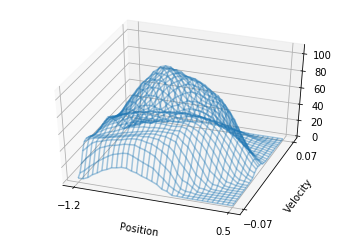

In [7]:
q_arr = eval_state_action_space(q_hat, env)
plot_q_max_3d(q_arr, env, labels=['Position', 'Velocity', ''], alpha=0.4)

# Recreate figure 10.1

We will need callback to capture q-value array for whole state-action space at specified episodes.

In [8]:
def callback(episode, tstep, model, trace):
    """Called from gradient_MC after every episode.
    
    Params:
        episode [int] - episode number
        tstep [int]   - timestep within episode
        model [obj]   - function approximator
        trace [list]  - list to write results to"""
    episodes = [1, 12, 104, 1000, 9000]
    if episode in episodes and tstep == 0:
        q_arr = eval_state_action_space(q_hat, env)
        trace.append(q_arr)

In [9]:
trace = []
q_hat = TileCodingFuncApprox(env.state_low, env.state_high, len(env.act_space),
                             learn_rate=0.3, num_tilings=8, init_val=0)
ep_semi_grad_sarsa(env, ep=20, gamma=1.0, eps=0.0, q_hat=q_hat, callback=callback, trace=trace)

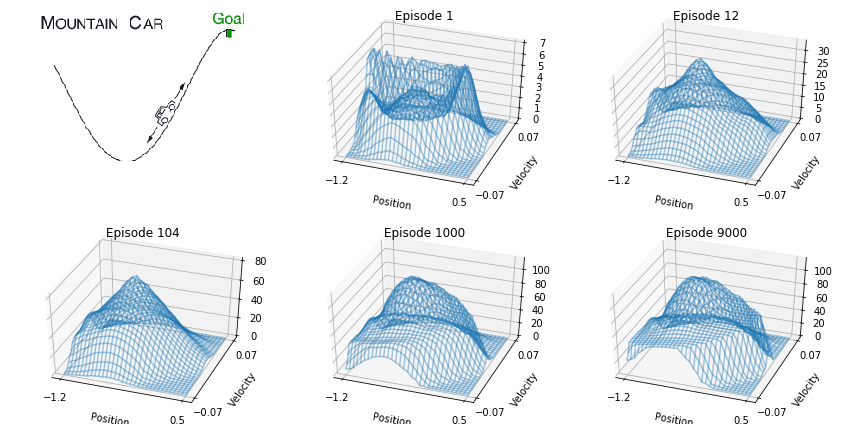

In [289]:
fig = plt.figure(figsize=[12,6])
ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232, projection='3d')
ax3 = fig.add_subplot(233, projection='3d')
ax4 = fig.add_subplot(234, projection='3d')
ax5 = fig.add_subplot(235, projection='3d')
ax6 = fig.add_subplot(236, projection='3d')

img = mpimg.imread('assets/1001_MountainCar_Image.png')
ax1.imshow(img)
ax1.axis('off')

labels = ['Position', 'Velocity', '']
plot_q_max_3d(trace[0], env, title='Episode 1', labels=labels, alpha=.4, axis=ax2)
plot_q_max_3d(trace[1], env, title='Episode 12', labels=labels, alpha=.4, axis=ax3)
plot_q_max_3d(trace[2], env, title='Episode 104', labels=labels, alpha=.4, axis=ax4)
plot_q_max_3d(trace[3], env, title='Episode 1000', labels=labels, alpha=.4, axis=ax5)
plot_q_max_3d(trace[4], env, title='Episode 9000', labels=labels, alpha=.4, axis=ax6)

plt.tight_layout()
plt.savefig('assets/fig_1001.png')
plt.show()